<a href="https://colab.research.google.com/github/wallacelw/Price-Forecasting-With-LSTM/blob/main/Prices_Forecasting_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Datasets available @

BTC, AAPL, MSFT, TSLA, ^IXIC(NASDAQ), ^BVSP(IBOVESPA):
https://finance.yahoo.com/

S&P 500:
https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks?select=sp500_index.csv

## Load Dataset and Preprocess It:

In [ ]:
import pandas as pd
import datetime

def str_to_datetime(s):
  """ Converts a string object to the respective datetime objects"""

  year, month, day = [int(i) for i in s.split('-')]
  return datetime.datetime(year=year, month=month, day=day)


price_dict = {
    "Adj Close" : "Price",
    "S&P500" : "Price"
}

def load_df(filename):
  df = pd.read_csv(filename)
  df.rename(columns = price_dict, inplace = True)

  # Univariate analysis
  df = df[["Date", "Price"]]

  # Convert date type objects to datetime object
  df["Date"] = df["Date"].apply(str_to_datetime)

  # Turn "Date" Column into dataframe index
  df.index = df.pop("Date")

  return df


df = load_df("MSFT.csv")

df

,Price
Date,
1986-03-13,0.060396
1986-03-14,0.062553
1986-03-17,0.063632
1986-03-18,0.062014
1986-03-19,0.060936
...,...
2023-11-02,348.320007
2023-11-03,352.799988
2023-11-06,356.529999


Text(0.5, 1.0, 'Full Dataset')

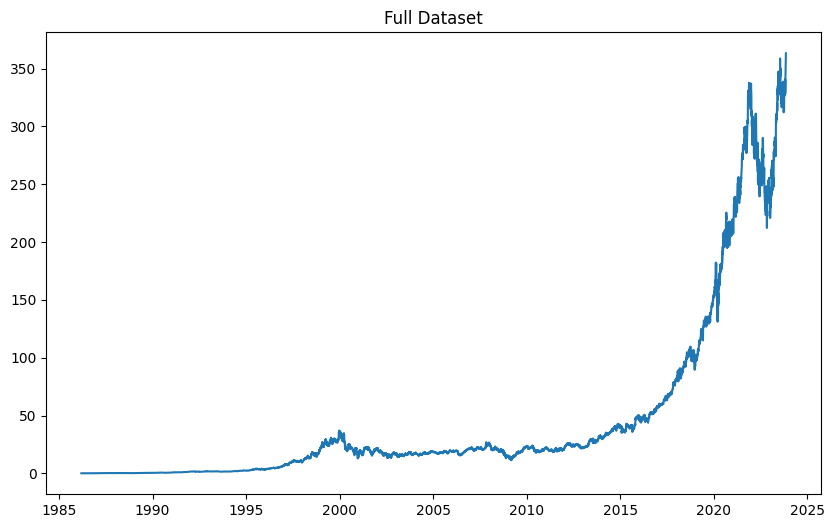

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(df.index, df["Price"])
plt.title("Full Dataset")

In [ ]:
# Choose the amount of days to consider from the dataset
days = 3000 # 0 for everything

# numbers of days to consider in the input of the model
lookback = 7

# Convert to a windowed Dataframe,
# so the last day prices (input) can predict the next day price (output)
def df_to_windowed(df, n=lookback, days_selected=days):
  data = pd.DataFrame()
  for i in range(n, 0, -1):
    data[f"Last-{i} Price"] = df["Price"].shift(periods=i)
  data["Price"] = df["Price"]

  return data.dropna()[-days_selected:]

windowed_df = df_to_windowed(df)

windowed_df

,Last-7 Price,Last-6 Price,Last-5 Price,Last-4 Price,Last-3 Price,Last-2 Price,Last-1 Price,Price
Date,,,,,,,,
2011-12-07,19.807947,19.784048,20.373426,20.134497,20.086702,20.469002,20.437143,20.389364
2011-12-08,19.784048,20.373426,20.134497,20.086702,20.469002,20.437143,20.389364,20.230066
2011-12-09,20.373426,20.134497,20.086702,20.469002,20.437143,20.389364,20.230066,20.469002
2011-12-12,20.134497,20.086702,20.469002,20.437143,20.389364,20.230066,20.469002,20.317678
2011-12-13,20.086702,20.469002,20.437143,20.389364,20.230066,20.469002,20.317678,20.516787
...,...,...,...,...,...,...,...,...
2023-11-02,330.529999,340.670013,327.890015,329.809998,337.309998,338.109985,346.070007,348.320007
2023-11-03,340.670013,327.890015,329.809998,337.309998,338.109985,346.070007,348.320007,352.799988
2023-11-06,327.890015,329.809998,337.309998,338.109985,346.070007,348.320007,352.799988,356.529999


Text(0.5, 1.0, 'Selected Interval from Dataset')

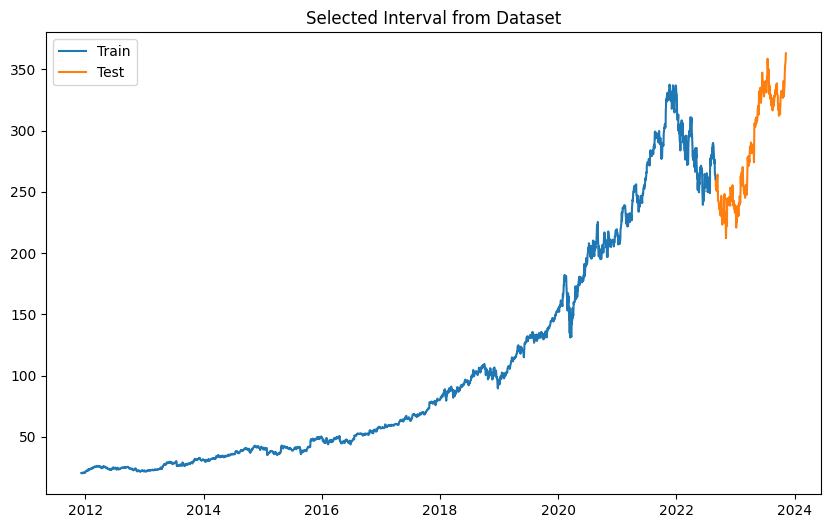

In [ ]:
# Separate data into 90% training and 10% test
split_marker = int(len(windowed_df) * 0.9)

def split_train_test(windowed, marker=split_marker):
  return windowed.iloc[:marker, :], windowed.iloc[marker:, :]

windowed_df_train, windowed_df_test = split_train_test(windowed_df)

plt.figure(figsize=(10,6))
plt.plot(windowed_df_train.index, windowed_df_train["Price"])
plt.plot(windowed_df_test.index, windowed_df_test["Price"])
plt.legend(["Train", "Test"])
plt.title("Selected Interval from Dataset")

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

def scale(windowed, fit_flag=False):
  if (fit_flag):
    return scaler.fit_transform(windowed)
  else:
    return scaler.transform(windowed)

scaled_train = scale(windowed_df_train, fit_flag=True)
scaled_test = scale(windowed_df_test)

pd.DataFrame(scaled_train).describe(), pd.DataFrame(scaled_test).describe()

(                 0            1            2            3            4  \
 count  2700.000000  2700.000000  2700.000000  2700.000000  2700.000000   
 mean     -0.477500    -0.476905    -0.477720    -0.477131    -0.476533   
 std       0.553541     0.553843     0.554666     0.554959     0.555264   
 min      -1.000000    -1.000000    -1.000000    -1.000000    -1.000000   
 25%      -0.896410    -0.896282    -0.898047    -0.897998    -0.897736   
 50%      -0.744886    -0.744799    -0.746086    -0.745651    -0.745506   
 75%      -0.211024    -0.206671    -0.207219    -0.206565    -0.205942   
 max       1.000000     1.000000     1.000000     1.000000     1.000000   
 
                  5            6            7  
 count  2700.000000  2700.000000  2700.000000  
 mean     -0.476627    -0.476062    -0.475502  
 std       0.555772     0.556017     0.556252  
 min      -1.000000    -1.000000    -1.000000  
 25%      -0.898487    -0.898379    -0.898140  
 50%      -0.746236    -0.745859   

In [ ]:
def split_columns(scaled_array, windowed):
  return (windowed.index, scaled_array[:, 0:-1], scaled_array[:, -1])

dates_train, X_train, Y_train = split_columns(scaled_train, windowed_df_train)
dates_test, X_test, Y_test = split_columns(scaled_test, windowed_df_test)

## Model Training

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

models = []

model1 = Sequential([
    layers.Input((lookback, 1)),
    layers.Conv1D(128, kernel_size=5),
    layers.Conv1D(128, kernel_size=3),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(128, return_sequences=False),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.01), # avoid overfitting
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

models.append(model1)

model2 = Sequential([
    layers.Input((lookback, 1)),
    layers.Conv1D(64, kernel_size=3),
    layers.LSTM(64, return_sequences=False),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.02), # avoid overfitting
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
  ])

models.append(model2)

model3 = Sequential([
    layers.Input((lookback, 1)),
    layers.Conv1D(128, kernel_size=5, activation='relu'),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(128, return_sequences=False),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.01), # avoid overfitting
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

models.append(model3)

def train_model(model, epochs=50, batch_size=64):
  model.compile(
      loss="mean_squared_error",
      optimizer=Adam(learning_rate=0.0001),
      metrics=["mean_absolute_error"] # extra metrics
    )

  model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=False)

  return model

trained_models = [train_model(i) for i in models]

## Results

In [ ]:
import numpy as np

def get_result(model, Xtrain=X_train, Xtest=X_test, windowed=windowed_df, skip_train=False):

  if (skip_train):
    conc_x = Xtest
  else:
    conc_x = np.concatenate((Xtrain, Xtest))

  predictions = model.predict(conc_x)

  result = np.hstack((conc_x, predictions))

  descaled_result = scaler.inverse_transform(result)

  result_df = windowed.copy()

  for i in range(lookback, 0, -1):
    result_df[f"Last-{i} Price"] = descaled_result[:, lookback-i]

  result_df["Price"] = descaled_result[:, lookback]

  return result_df

results_dfs = [get_result(i) for i in trained_models]

94/94 [==============================] - 2s 6ms/step


## Evaluation Metrics:

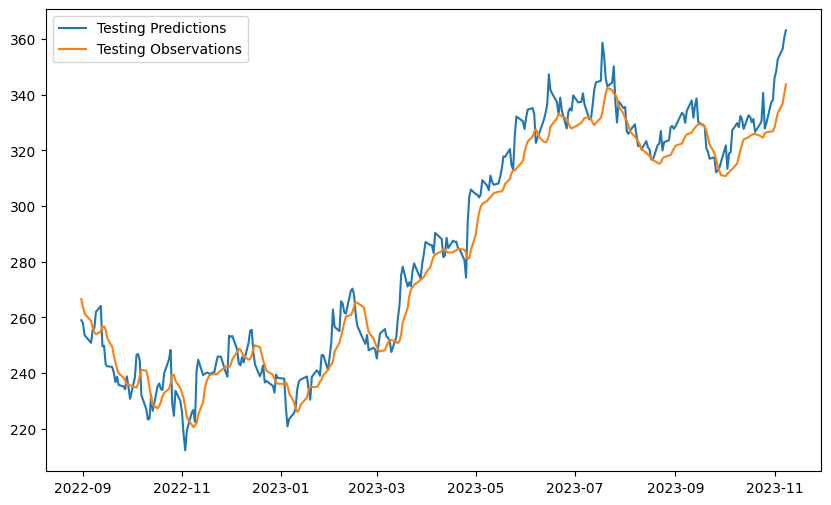

For the Testing Prediction curve of model: 0
Mean Absolute Error:  6.808934950897147
Mean Square Error:  71.14523990555458
R2  0.9601688536872144


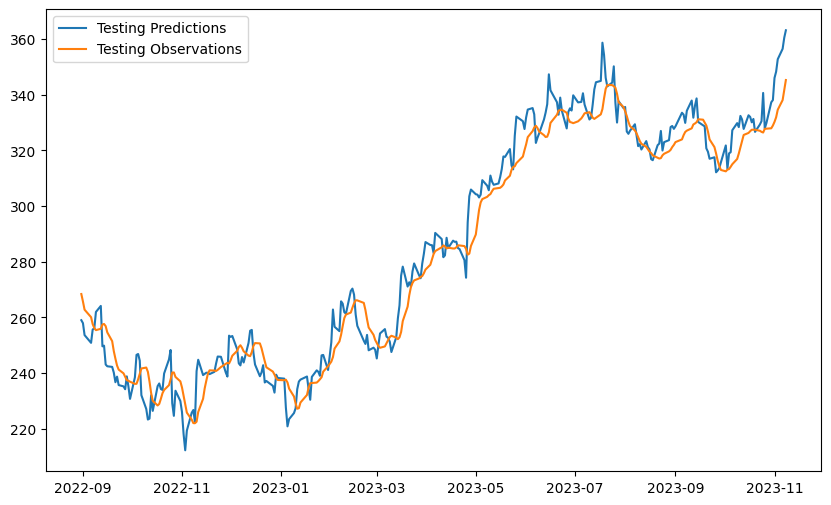

For the Testing Prediction curve of model: 1
Mean Absolute Error:  6.390368188202297
Mean Square Error:  63.7003644299841
R2  0.9643369178436016


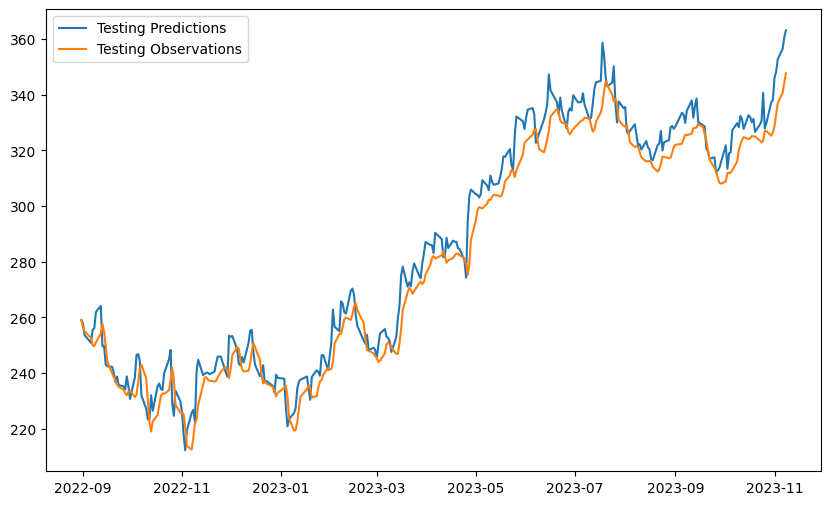

For the Testing Prediction curve of model: 2
Mean Absolute Error:  6.616626419619749
Mean Square Error:  66.99066576616428
R2  0.9624948202681556


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def plot_evaluate_model(resultDF, idx, windowedDfTest=windowed_df_test, dates=dates_test, marker=split_marker):

  y_true_test = windowedDfTest["Price"]
  y_pred_test = resultDF["Price"].iloc[marker:]

  plt.figure(figsize=(10,6))
  plt.plot(dates, y_true_test)
  plt.plot(dates, y_pred_test)
  plt.legend(["Testing Predictions", "Testing Observations"])
  plt.show()

  print(f"For the Testing Prediction curve of model: {idx}")
  print("Mean Absolute Error: ", mean_absolute_error(y_true=y_true_test, y_pred=y_pred_test))
  print("Mean Square Error: ", mean_squared_error(y_true=y_true_test, y_pred=y_pred_test))
  print("R2 ", r2_score(y_true=y_true_test, y_pred=y_pred_test))

for idx, result_df in enumerate(results_dfs):
  plot_evaluate_model(result_df, idx)

## Using the same model for another market

Checking model's generalization capabilities

<ipython-input-48-b61d031d6763>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = df["Date"].apply(str_to_datetime)


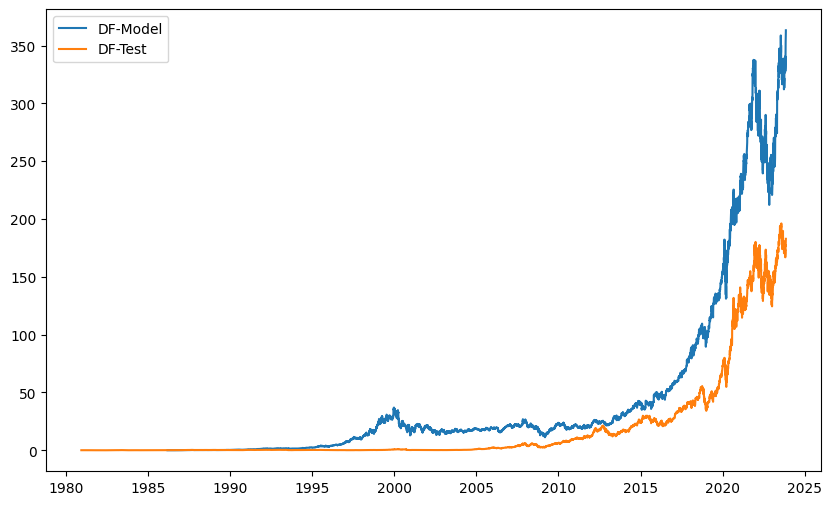

In [ ]:
# Test Dataset
df2 = load_df("AAPL.csv")

plt.figure(figsize=(10,6))
plt.plot(df.index, df["Price"])
plt.plot(df2.index, df2["Price"])
plt.legend(["DF-Model", "DF-Test"])

94/94 [==============================] - 0s 4ms/step


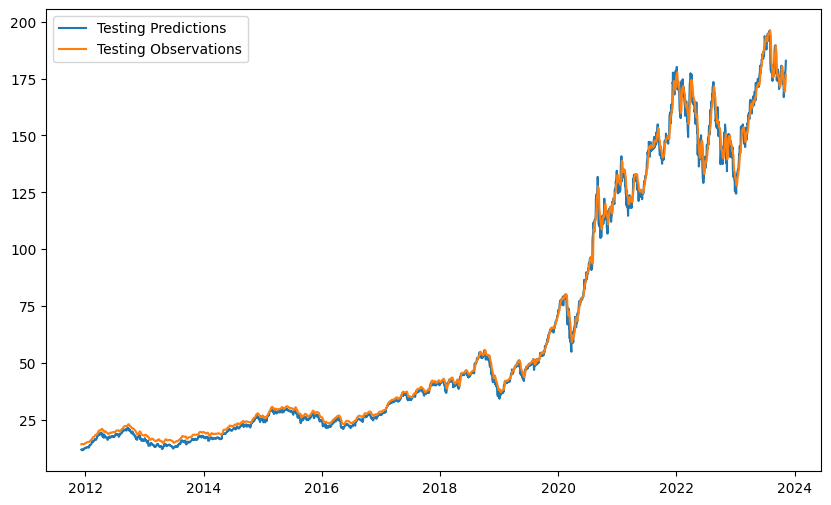

For the Testing Prediction curve of model: 0
Mean Absolute Error:  1.9836298630381155
Mean Square Error:  7.148866623602841
R2  0.9976456028164334
94/94 [==============================] - 0s 3ms/step


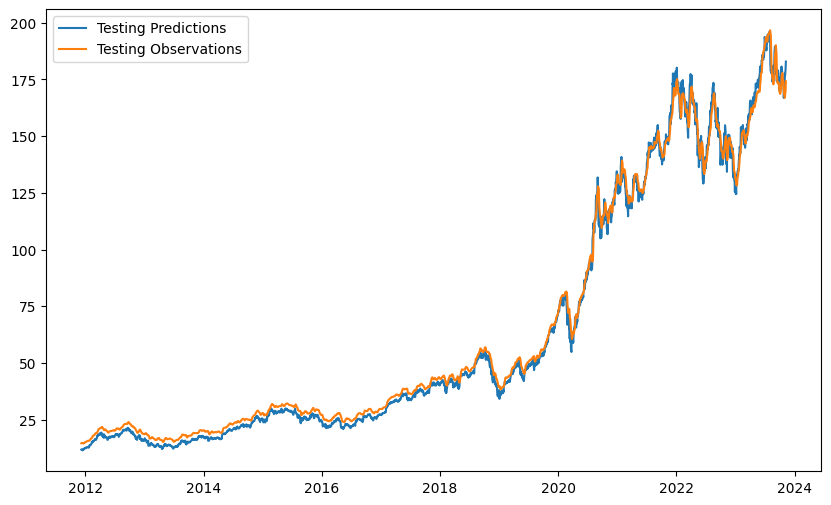

For the Testing Prediction curve of model: 1
Mean Absolute Error:  2.7343905553264904
Mean Square Error:  10.602833747150187
R2  0.9965080783813066
94/94 [==============================] - 0s 4ms/step


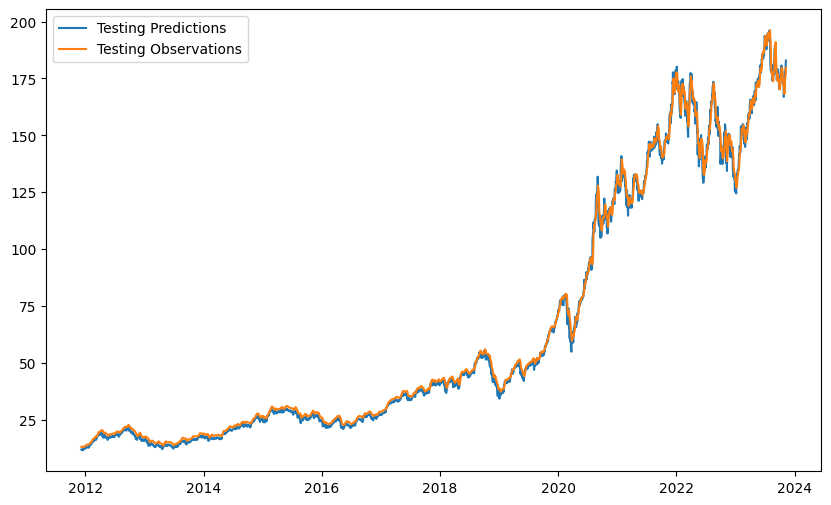

For the Testing Prediction curve of model: 2
Mean Absolute Error:  1.7064017917326897
Mean Square Error:  5.3132041140041215
R2  0.9982501571982859


In [ ]:
windowed_df2 = df_to_windowed(df2)

scaled_df2 = scale(windowed_df2)
dates2, X_test2, Y_test2 = split_columns(scaled_df2, windowed_df2)

for idx, model in enumerate(trained_models):
  result_df2 = get_result(model, Xtrain=[], Xtest=X_test2, windowed=windowed_df2, skip_train=True)
  plot_evaluate_model(result_df2, idx, windowed_df2, dates2, 0)